In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.nestcomparison import NestComparison
from pelenet.network import ReservoirNetwork

# Official modules
import numpy as np
import scipy
from scipy import stats
from scipy.sparse import csr_matrix
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import os
from time import time
import copy

In [2]:
# Initilize utils
utils = Utils.instance()

In [3]:
def execRun(name, i):
    """
    Read data
    """
    # Add input
    inp = np.load('data/nest2/'+str(name)+'/input_pop_'+str(i)+'.npy')

    # Add mask
    exex = csr_matrix(np.load('data/nest2/'+str(name)+'/weights_ee_'+str(i)+'.npy'))
    exin = csr_matrix(np.load('data/nest2/'+str(name)+'/weights_ei_'+str(i)+'.npy'))
    inex = csr_matrix(np.load('data/nest2/'+str(name)+'/weights_ii_'+str(i)+'.npy'))
    inin = csr_matrix(np.load('data/nest2/'+str(name)+'/weights_ie_'+str(i)+'.npy'))
    ma = { 'exex': exex, 'inin': inin, 'inex': inex, 'exin': exin }
    
    """
    Run experiment
    """
    # Init experiment
    exp = NestComparison()

    # Build network
    exp.net = ReservoirNetwork(exp.p)

    # Define mask
    exp.net.initialMasks.exex = ma['exex']
    exp.net.initialMasks.exin = ma['exin']
    exp.net.initialMasks.inex = ma['inex']
    exp.net.initialMasks.inin = ma['inin']

    # Set weights
    exp.setSparseWeightMatrix()

    # Connect
    exp.net.connectReservoir()

    # Add patch input
    exp.net.addRepeatedPatchGenerator(idc = inp-1)

    # Build the network structure
    exp.net.build()

    # Run network
    exp.run()
    
    """
    Store data
    """
    
    spikes = exp.net.exSpikeTrains[:,exp.p.resetOffset:500+exp.p.resetOffset]
    np.save('data/loihi/'+str(name)+'/spikes_'+str(i)+'.npy', spikes)
    
    #if i==0:
    #    parameters = copy.deepcopy(exp.p)
    #    np.save('data/loihi/'+str(name)+'/parameters.npy',parameters)

In [4]:
#name = 'one_network_15_locations'
#name = 'one_location_15_networks'

#for i in range(13,15):
#    execRun(name, i)

In [5]:
# Get NEST spikes
def translateNestSpikes(nest):
    spikes = []

    mi, ma = int(np.floor(np.min(nest[0]))), int(np.ceil(np.max(nest[0])))
    for t in range(mi, ma):
        idcs = []
        for i in np.arange(0.0,1.0,0.1):
            idcs.extend(np.where(np.isclose(nest[0], t+i))[0])
        spkVec = np.zeros(p.reservoirExSize)
        spkVec[nest[1, idcs].astype(int)-1] = 1
        spikes.append(spkVec)
        
    return np.array(spikes).T

In [6]:
def readNestSpikes(name):
    nest = []

    for i in range(15):
        # Add times
        times = np.load('data/nest2/'+str(name)+'/spike_times_'+str(i)+'.npy')

        # Add indices
        lastIdc = np.where(times < 509)[0][-1]
        inds = np.load('data/nest2/'+str(name)+'/spike_indices_'+str(i)+'.npy')
        
        # Combine
        raw = np.array([times[:lastIdc], inds[:lastIdc]])
        
        # Translates spikes from Nest in Loihi format
        nest.append(translateNestSpikes(raw))

    # Return list of nest results
    return np.array(nest)

In [7]:
def readLoihiParameters():
    #return np.load('data/loihi/'+str(name)+'/parameters.npy')
    exp = NestComparison()
    return exp.p

In [8]:
def readLoihiSpikes(name):
    loihi = []

    for i in range(15):
        loihi.append(np.load('data/loihi/'+str(name)+'/spikes_'+str(i)+'.npy'))
        
    return np.array(loihi)

In [9]:
p = readLoihiParameters()

sn15l = readNestSpikes('one_network_15_locations')
sl15l = readLoihiSpikes('one_network_15_locations')

sn15n = readNestSpikes('one_location_15_networks')
sl15n = readLoihiSpikes('one_location_15_networks')

In [10]:
twoCols = ['#41aab7', '#b74d41']

# Matplotlib parameters
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.family'] = 'CMU Sans Serif'
plt.rcParams['font.size'] = 14

# Spike trains

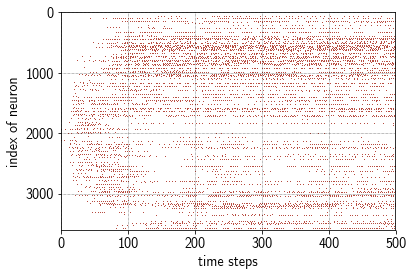

In [11]:
cmap = colors.ListedColormap(['#ffffff', twoCols[1]])
#plt.title('NEST Reservoir spikes')
plt.xlabel('time steps')
plt.ylabel('index of neuron')
plt.imshow(sn15n[7], cmap=cmap, aspect='auto')
#plt.savefig(exp2.net.plot.plotDir + 'spikes_raster_nest.svg')
plt.savefig('plots/figure3/spikes_raster_nest.svg')
pl = plt.show()

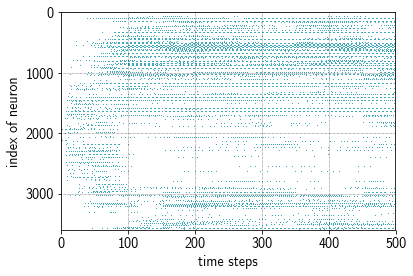

In [12]:
cmap = colors.ListedColormap(['#ffffff', twoCols[0]])
#plt.title('NEST Reservoir spikes')
plt.xlabel('time steps')
plt.ylabel('index of neuron')
plt.imshow(sl15n[7], cmap=cmap, aspect='auto')
#plt.savefig(exp2.net.plot.plotDir + 'spikes_raster_nest.svg')
plt.savefig('plots/figure3/spikes_raster_loihi.svg')
pl = plt.show()

# Firing rate over time

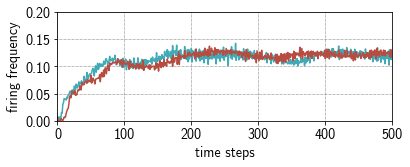

In [46]:
idExp = 7

sl1m0 = np.mean(sl15n[idExp], axis=0)
sn1m0 = np.mean(sn15n[idExp], axis=0)

plt.figure(figsize=(6,2))
plt.plot(sl1m0, color=twoCols[0], label="Loihi")
plt.plot(sn1m0, color=twoCols[1], label="NEST")
plt.xlabel('time steps')
plt.ylabel('firing frequency')
plt.yticks(np.arange(0, 0.21, step=0.05))
plt.xlim((0,500))
plt.ylim((0,0.2))
#plt.savefig(exp1.net.plot.plotDir + 'firingrate_exp1.svg')
plt.savefig('plots/figure3/firingrate-over-time.svg')
pl = plt.show()

# Fano factors / coefficient of variation over all simulations

In [14]:
np.sum(sl15n[0,0]) != 0

True

In [15]:
def fano(self, spikes):
    # Get shape
    shp = spikes.shape
    # Iterate over all trials
    ff = []
    for i in range(shp[0]):
        # Get mean and standard deviation of all spike trains
        mn = np.mean(spikes[i], axis=1)
        var = np.var(spikes[i], axis=1)

        # Get indices of zero-values
        mask = (mn != 0)
        
        # Append mean fano factors from all neurons with spiking activity
        ff.append(np.mean(var[mask]/mn[mask]))

    # Return mean fano factors for every trial
    return ff

In [16]:
def isicv(spikes):
    shp = spikes.shape
    cvs = []
    for k in range(shp[0]):
        for i in range(shp[1]):
            if np.sum(spikes[k,i]) != 0:
                isi = np.bincount(np.cumsum(spikes[0,i]).astype(int))
                cv = np.std(isi)/np.mean(isi)
                cvs.append(cv)
    return cvs

In [17]:
sl15n_cv = isicv(sl15n)
sn15n_cv = isicv(sn15n)
sl15l_cv = isicv(sl15l)
sn15l_cv = isicv(sn15l)

In [18]:
# Networks
print(np.mean(sl15n_cv))
print(np.mean(sn15n_cv))

# Locations
print(np.mean(sl15l_cv))
print(np.mean(sn15l_cv))

2.501179066065166
1.8009826468251733
1.1198787381859243
1.5665086680632536


In [19]:
# Calculate fano factors
sl15n_ff = utils.fano(sl15n)
sn15n_ff = utils.fano(sn15n)
sl15l_ff = utils.fano(sl15l)
sn15l_ff = utils.fano(sn15l)

# Calculate coefficient of variation
sl15n_cv = utils.cv(sl15n)
sn15n_cv = utils.cv(sn15n)
sl15l_cv = utils.cv(sl15l)
sn15l_cv = utils.cv(sn15l)

In [20]:
print('fano factor')
# mannwhitneyu networks
print("15 networks - Loihi: {:.5f} +/- {:.5f}, NEST: {:.5f} +/- {:.5f}".format(np.mean(sl15n_ff), np.std(sl15n_ff), np.mean(sn15n_ff), np.std(sn15n_ff)))
# mannwhitneyu locations
print("15 locations - Loihi: {:.5f} +/- {:.5f}, NEST: {:.5f} +/- {:.5f}".format(np.mean(sl15l_ff), np.std(sl15l_ff), np.mean(sn15l_ff), np.std(sn15l_ff)))

print('coefficient of variation')
# mannwhitneyu networks
print("15 networks - Loihi: {:.5f}, NEST: {:.5f}".format(np.mean(sl15n_cv), np.mean(sn15n_cv)))
# mannwhitneyu locations
print("15 locations - Loihi: {:.5f}, NEST: {:.5f}".format(np.mean(sl15l_cv), np.mean(sn15l_cv)))

fano factor
15 networks - Loihi: 0.84819 +/- 0.01955, NEST: 0.86425 +/- 0.01327
15 locations - Loihi: 0.83344 +/- 0.02521, NEST: 0.86526 +/- 0.01265
coefficient of variation
15 networks - Loihi: 4.94484, NEST: 5.11421
15 locations - Loihi: 4.78083, NEST: 4.80307


In [21]:
# Check normality
print(scipy.stats.shapiro(sl15n_ff))
print(scipy.stats.shapiro(sn15n_ff))
print(scipy.stats.shapiro(sl15l_ff))
print(scipy.stats.shapiro(sn15l_ff))

print(scipy.stats.shapiro(sl15n_cv))
print(scipy.stats.shapiro(sn15n_cv))
print(scipy.stats.shapiro(sl15l_cv))
print(scipy.stats.shapiro(sn15l_cv))

(0.9240914583206177, 0.22231394052505493)
(0.9758252501487732, 0.9330110549926758)
(0.9226092100143433, 0.21108855307102203)
(0.8850654363632202, 0.05650060623884201)
(0.8980015516281128, 0.08871825784444809)
(0.9571902751922607, 0.6437092423439026)
(0.9375640749931335, 0.35272642970085144)
(0.8393640518188477, 0.01232131663709879)


In [22]:
# Test for equal variances
print(scipy.stats.levene(sl15n_ff, sn15n_ff))
print(scipy.stats.levene(sl15l_ff, sn15l_ff))

print(scipy.stats.levene(sl15n_cv, sn15n_cv))
print(scipy.stats.levene(sl15l_cv, sn15l_cv))

LeveneResult(statistic=3.324360004906396, pvalue=0.07895407888883385)
LeveneResult(statistic=5.692904791871569, pvalue=0.02403587061048444)
LeveneResult(statistic=0.08761374122562585, pvalue=0.7694172283480585)
LeveneResult(statistic=1.036702220555845, pvalue=0.317307292342006)


In [23]:
print('fano factor')
# ttest networks
print(scipy.stats.ttest_ind(sl15n_ff, sn15n_ff))
# ttest locations
print(scipy.stats.ttest_ind(sl15l_ff, sn15l_ff))

print('coefficient of variation')
# ttest networks
print(scipy.stats.ttest_ind(sl15n_cv, sn15n_cv))
# ttest locations
print(scipy.stats.ttest_ind(sl15l_cv, sn15l_cv))

fano factor
Ttest_indResult(statistic=-2.5436021447803854, pvalue=0.016777450225103727)
Ttest_indResult(statistic=-4.2220898928324235, pvalue=0.0002310404955254264)
coefficient of variation
Ttest_indResult(statistic=-1.6047564253138746, pvalue=0.1197689039526302)
Ttest_indResult(statistic=-0.2545580585810469, pvalue=0.800924763113805)


# Mean firing rate over all simultions

In [24]:
import matplotlib.patches as mpatches

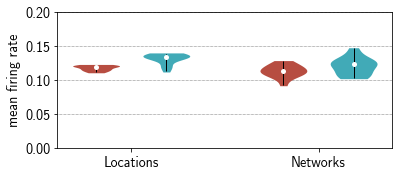

In [25]:
start = 100

fig = plt.figure(figsize=(6,2.5))
barWidth = 1

# Values and errors
sl15l_f = np.mean(sl15l[:,:,start:], axis=(1,2))  # Loihi, Locations
sl15n_f = np.mean(sl15n[:,:,start:], axis=(1,2))  # Loihi, Networks
sn15l_f = np.mean(sn15l[:,:,start:], axis=(1,2))  # NEST, Locations
sn15n_f = np.mean(sn15n[:,:,start:], axis=(1,2))  # NEST, Networks

# Loihi
#r1 = [1, 3.5]
#vl = [np.mean(sl15l_f), np.mean(sl15n_f)]  
#el = [np.std(sl15l_f), np.std(sl15n_f)]

# NEST
#r2 = [2, 4.5]
#vn = [np.mean(sn15l_f), np.mean(sn15n_f)]
#en = [np.std(sn15l_f), np.std(sn15n_f)]

#plt.bar(r1, vl, yerr=el, width=barWidth, color=twoCols[0], ecolor='black', label='Loihi', error_kw=dict(lw=1, capthick=1, capsize=4))
#plt.bar(r2, vn, yerr=en, width=barWidth, color=twoCols[1], ecolor='black', label='NEST', error_kw=dict(lw=1, capthick=1, capsize=4))

#inds = [0,1,2.5,3.5]
inds = [0,0.75,2,2.75]
partsNEST = plt.violinplot([sn15l_f, sn15n_f], positions=[inds[0],inds[2]], showmeans=False, showmedians=False, showextrema=False)
partsLoihi = plt.violinplot([sl15l_f, sl15n_f], positions=[inds[1],inds[3]], showmeans=False, showmedians=False, showextrema=False)

for pc in partsNEST['bodies']:
    pc.set_facecolor(twoCols[1])
    pc.set_edgecolor('#000000')
    pc.set_alpha(1)

for pc in partsLoihi['bodies']:
    pc.set_facecolor(twoCols[0])
    pc.set_edgecolor('#000000')
    pc.set_alpha(1)

# Calculate some statistics to build voilin plot
data = [sn15l_f, sl15l_f, sn15n_f, sl15n_f]
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
mins, maxs = np.min(data, axis=1), np.max(data, axis=1)

# Correct a bit for nicer display
mins = mins+0.001
maxs = maxs-0.001

# Add statistics (median, min, max)
ax = fig.axes[0]
ax.scatter(inds, medians, marker='o', color='white', s=25, zorder=3)
ax.vlines(inds, mins, maxs, color='k', linestyle='-', lw=1)

# Correct xticks
plt.xticks([inds[0]+(inds[1]-inds[0])/2, inds[2]+(inds[3]-inds[2])/2], ['Locations', 'Networks'])
#plt.yticks(np.arange(0, 0.151, step=0.025))

# Set up grid
plt.grid(axis='x')

plt.ylabel('mean firing rate')
#plt.xlim(-0.25, 1.25)
#plt.ylim(0.0,0.2)
plt.ylim(0.0,0.2)
#plt.savefig(exp1.net.plot.plotDir + 'meanfiringrate.svg')
plt.savefig('plots/figure3/meanfiringrate.svg')
pl = plt.show()

In [26]:
# Locations
print('Loihi: min {:.2f} max {:.2f}'.format(np.min(sl15l_f), np.max(sl15l_f)))
print('NEST: min {:.2f} max {:.2f}'.format(np.min(sn15l_f), np.max(sn15l_f)))
# Networks
print('Loihi: min {:.2f} max {:.2f}'.format(np.min(sl15n_f), np.max(sl15n_f)))
print('NEST: min {:.2f} max {:.2f}'.format(np.min(sn15n_f), np.max(sn15n_f)))

Loihi: min 0.11 max 0.14
NEST: min 0.11 max 0.12
Loihi: min 0.10 max 0.15
NEST: min 0.09 max 0.13


In [27]:
print("Locations: Loihi {:.4f} +/- {:.4f} : NEST {:.4f} +/- {:.4f}".format(np.mean(sl15l_f), np.std(sl15l_f), np.mean(sn15l_f), np.std(sn15l_f)))
print("Networks: Loihi {:.4f} +/- {:.4f} : NEST {:.4f} +/- {:.4f}".format(np.mean(sl15n_f), np.std(sl15n_f), np.mean(sn15n_f), np.std(sn15n_f)))

Locations: Loihi 0.1313 +/- 0.0078 : NEST 0.1177 +/- 0.0038
Networks: Loihi 0.1203 +/- 0.0126 : NEST 0.1131 +/- 0.0092


In [28]:
"""
error variation network
x     0 loc       0 loihi
x     0 loc       1 nest
x     1 nets      0 loihi      
x     1 nets      1 nest
"""

'\nerror variation network\nx     0 loc       0 loihi\nx     0 loc       1 nest\nx     1 nets      0 loihi      \nx     1 nets      1 nest\n'

In [29]:
aovData = np.vstack((
    np.vstack((sl15l_f, np.zeros(len(sl15l_f)), np.zeros(len(sl15l_f)))).T,
    np.vstack((sl15n_f, np.zeros(len(sl15n_f)), np.ones(len(sl15n_f)))).T,
    np.vstack((sn15l_f, np.ones(len(sn15l_f)), np.zeros(len(sn15l_f)))).T,
    np.vstack((sn15n_f, np.ones(len(sn15n_f)), np.ones(len(sn15n_f)))).T
))

In [30]:
data = {
    'error': aovData[:,0],
    'variation': aovData[:,1],
    'hardware': aovData[:,2]
}

In [31]:
formula = 'error ~ C(variation) + C(hardware) + C(variation):C(hardware)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

In [32]:
aov_table

,sum_sq,df,F,PR(>F)
C(variation),0.001614,1.0,18.847511,0.000060
C(hardware),0.000911,1.0,10.634742,0.001892
C(variation):C(hardware),0.000157,1.0,1.829915,0.181574
Residual,0.004797,56.0,NaN,NaN


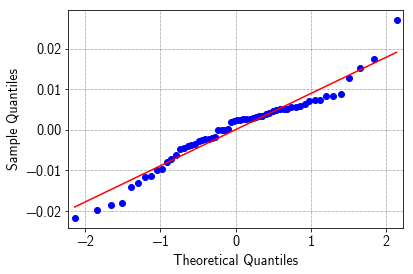

In [33]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [34]:
print(scipy.stats.shapiro(sl15l_f))
print(scipy.stats.shapiro(sn15l_f))
print(scipy.stats.shapiro(sl15n_f))
print(scipy.stats.shapiro(sn15n_f))

(0.8317275047302246, 0.009672505781054497)
(0.9060710668563843, 0.1178734228014946)
(0.9530928730964661, 0.5744109153747559)
(0.9718447923660278, 0.8843746781349182)


In [35]:
print(scipy.stats.levene(sl15l_f, sn15l_f))
print(scipy.stats.levene(sl15n_f, sn15n_f))

LeveneResult(statistic=1.5871264408771293, pvalue=0.21813700639354286)
LeveneResult(statistic=1.4488548949833309, pvalue=0.23878978335936826)


In [36]:
print(scipy.stats.mannwhitneyu(sl15l_f, sn15l_f))
print(scipy.stats.mannwhitneyu(sl15n_f, sn15n_f))

MannwhitneyuResult(statistic=27.0, pvalue=0.00021123378834695988)
MannwhitneyuResult(statistic=78.0, pvalue=0.07923230299910178)


In [37]:
print(scipy.stats.pearsonr(sl15l_f, sn15l_f))
print(scipy.stats.pearsonr(sl15n_f, sn15n_f))

(0.4775944816564992, 0.07179240150720048)
(0.5590379323347727, 0.03027434850358785)


# Clustered frequencies

In [38]:
def getClusteredFrequencies(sm, binSize):
    topologyIndices = np.arange(p.reservoirExSize).reshape((p.topologySize, p.topologySize))
    numBins = int(p.topologySize / binSize)

    smb = []
    for i in range(numBins):
        # Define from and to variables for index i
        ifr, ito = i*binSize, (i+1)*binSize
        for j in range(numBins):
            # Define from and to variables for index j
            jfr, jto = j*binSize, (j+1)*binSize
            # Get topology indices and set connect neurons between output cluster and output neuron
            idc = topologyIndices[ifr:ito,jfr:jto]
            smb.append(np.mean(sm[idc]))
    return np.array(smb)

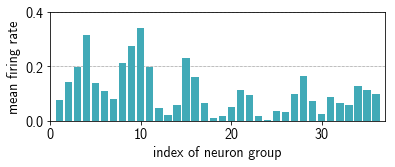

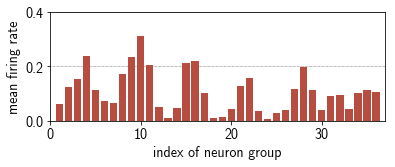

In [39]:
binSize = 10
numclusters = int(p.reservoirExSize / np.square(binSize))


idExp = 7

slmb = getClusteredFrequencies(np.mean(sl15n[idExp], axis=1), binSize)
snmb = getClusteredFrequencies(np.mean(sn15n[idExp], axis=1), binSize)

# Plot Loihi
plt.figure(figsize=(6,2))
plt.bar(1+np.arange(numclusters), slmb, color=twoCols[0])
#plt.title('Loihi')
plt.xlabel('index of neuron group')
plt.ylabel('mean firing rate')
#plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.xlim((0,numclusters+1))
plt.ylim((0,0.4))
plt.grid(axis='x')
#plt.savefig(exp1.net.plot.plotDir + 'frequency_loihi.svg')
plt.savefig('plots/figure3/frequency_loihi.svg')
pl = plt.show()

# Plot Nest
plt.figure(figsize=(6,2))
plt.bar(1+np.arange(numclusters), snmb, color=twoCols[1])
#plt.title('Nest')
plt.xlabel('index of neuron group')
plt.ylabel('mean firing rate')
#plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.xlim((0,numclusters+1))
plt.ylim((0,0.4))
plt.grid(axis='x')
#plt.savefig(exp1.net.plot.plotDir + 'frequency_nest.svg')
plt.savefig('plots/figure3/frequency_nest.svg')
pl = plt.show()

In [40]:
print(scipy.stats.ks_2samp(slmb/np.sum(slmb), snmb/np.sum(snmb)))

Ks_2sampResult(statistic=0.11111111111111116, pvalue=0.9713163247270222)


In [41]:
slmbs = []
snmbs = []
for i in range(7):
    # Cluster and sort frequencies from loihi
    sl_cl = getClusteredFrequencies(np.mean(sl15n[i], axis=1), binSize)
    slmbs.append(np.sort(sl_cl)[::-1])
    # Cluster and sort frequencies from nest
    sn_cl = getClusteredFrequencies(np.mean(sn15n[i], axis=1), binSize)
    snmbs.append(np.sort(sn_cl)[::-1])

slmbs_mn = np.mean(slmbs, axis=0)
snmbs_mn = np.mean(snmbs, axis=0)

<BarContainer object of 36 artists>

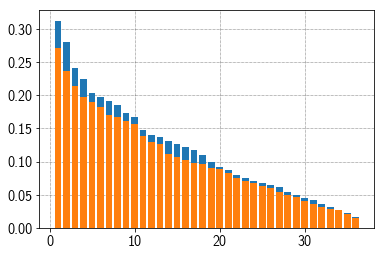

In [42]:
plt.bar(1+np.arange(numclusters), slmbs_mn)
plt.bar(1+np.arange(numclusters), snmbs_mn)

In [43]:
print(scipy.stats.ks_2samp(slmbs_mn/np.sum(slmbs_mn), snmbs_mn/np.sum(snmbs_mn)))

Ks_2sampResult(statistic=0.05555555555555558, pvalue=0.9999999900335537)
